##### Grading Feedback Cell

# IST 718: Big Data Analytics

- Professor: Willard Williamson <wewillia@syr.edu>
- Faculty Assistant: Yash Pasar <yspasar@syr.edu>
## General instructions:

- You are welcome to discuss the problems with your classmates but __you are not allowed to copy any part of your answers from your classmates.  Short code snippets are allowed from the internet.  Code from the class text books or class provided code can be copied in its entirety.__
- There could be tests in some cells (i.e., `assert` and `np.testing.` statements). These tests (if present) are used to grade your answers. **However, the professor and FAs could use __additional__ test for your answer. Think about cases where your code should run even if it passess all the tests you see.**
- Before submitting your work, remember to check for run time errors with the following procedure:
`Kernel`$\rightarrow$`Restart and Run All`.  All runtime errors will result in a minimum penalty of half off.
- Data Bricks is the official class runtime environment so you should test your code on Data Bricks before submission.  If there is a runtime problem in the grading environment, we will try your code on Data Bricks before making a final grading decision.
- All plots shall include a title, and axis labels.
- Grading feedback cells are there for graders to provide feedback to students.  Don't change or remove grading feedback cells.
- Don't add or remove files from your git repo.
- Do not change file names in your repo.  This also means don't change the title of the ipython notebook.
- __Only use spark, spark machine learning, spark data frames, RDD's, and map reduce to solve all problems unless instructed otherwise.__

In [1]:
# read only cell

import os

# get the databricks runtime version
db_env = os.getenv("DATABRICKS_RUNTIME_VERSION")

# Define a function to read the data file.  The full path data file name is constructed
# by checking runtime environment variables to determine if the runtime environment is 
# databricks, or a student's personal computer.  The full path file name is then
# constructed based on the runtime env.
# 
# Params
#   data_file_name: The base name of the data file to load
# 
# Returns the full path file name based on the runtime env
#
def get_training_filename(data_file_name):    
    # if the databricks env var exists
    if db_env != None:
        # build the full path file name assuming data brick env
        full_path_name = "/FileStore/tables/%s" % data_file_name
    # else the data is assumed to be in the same dir as this notebook
    else:
        # Assume the student is running on their own computer and load the data
        # file from the same dir as this notebook
        full_path_name = data_file_name
    
    # return the full path file name to the caller
    return full_path_name

In [2]:
# import statements here
# create spark and sparkcontext objects
from pyspark.sql import SparkSession
from pyspark.sql import Row
import numpy as np
import pandas as pd
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

# Moore's Law
The frequently cited “Moore’s Law” originated with a 1965 article in Electronics magazine that said the number of transistors in a given area would double every year.

### ONLY use spark functions unless the question instructions say otherwise.

## Question 1 Load the Transistor Data (5 pts)
- Read the MooresLaw.txt file into a spark data frame named trans_df using only spark.  The columns should be named as per the header in the txt file.
- Print the first 5 rows of trans_df 
- Print the shape of trans_df (num_rows, num_cols)
- Make sure to use the get_training_filename function above to obtain the file name based on your runtime environment

In [3]:
data_rdd = sc.textFile(get_training_filename('mooresLaw.txt'))

def map_processor(e):
    
    x = e.split('\t')
        
    return Row(Intel_Processor = x[0], Year = x[1], Transistors = x[2])

trans_df = data_rdd.map(map_processor).filter(lambda x: x[0] != 'Intel Processor').toDF()

trans_df = trans_df.selectExpr("cast(Intel_Processor as string) Intel_Processor",
                               "cast(Year as float) Year",
                               "cast(Transistors as long) Transistors")
trans_df.show(5)

print("Shape of trans_df:", (trans_df.count(), len(trans_df.columns)))

+---------------+------+-----------+
|Intel_Processor|  Year|Transistors|
+---------------+------+-----------+
|           4004|1971.9|       2300|
|           8008|1972.3|       3500|
|           8080|1974.3|       6000|
|           8085|1976.3|       6500|
|           8086|1978.5|      29000|
+---------------+------+-----------+
only showing top 5 rows

Shape of trans_df: (74, 3)


##### Grading Feedback Cell

## Question 2 Transistor Data Cleanup (5 pts)
- Drop all columns in trans_df except the Year and Transistors column.
- Drop rows in trans_df that contain NaN vales
- Prove that trans_df does not contain NaN values by showing a single integer sum of the number of Nan values in the dataframe (should equal 0)

In [4]:
trans_df = trans_df.drop('Intel_Processor')

trans_df = trans_df.filter((trans_df.Year.isNotNull()) & (trans_df.Transistors.isNotNull()))

print("Number of NaN values in trans_df dataframe:", trans_df.filter((trans_df.Year.isNull()) | (trans_df.Transistors.isNull())).count())

Number of NaN values in trans_df dataframe: 0


##### Grading Feedback Cell

## Question 3 Transistor Data Exploration (10 pts)


### Question 3a (3 pts) 
Explore the data in trans_df by plotting transistors vs. year with a scatter plot.  You may use packages outside of spark to perform the task in question 3a.

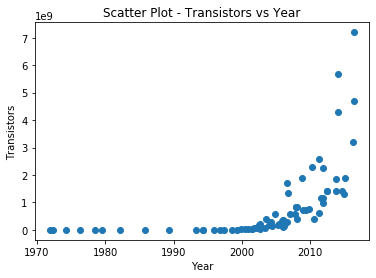

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.scatter(trans_df.rdd.map(lambda row: row.Year).collect(), 
            trans_df.rdd.map(lambda row: row.Transistors).collect())
plt.xlabel("Year")
plt.ylabel("Transistors")
plt.title("Scatter Plot - Transistors vs Year")

plt.show()

##### Grading Feedback Cell

### Question 3b (3 pts)
Compute the correlation between year and number of transistors in the trans_df using spark.  Print the resulting correlation value.  Interpret the correlation in words in the provided markdown cell.

In [6]:
from pyspark.sql import functions as fn

trans_df.select(fn.corr('Year', 'Transistors')).show()

+-----------------------+
|corr(Year, Transistors)|
+-----------------------+
|     0.5434354144405419|
+-----------------------+



##### Grading Feedback Cell

### Question 3c (4 pts) 
- Interpret the correlation value computed above in the markdown cell below.

- There is a moderate positive linear relationship between Years and Transistors.
- The number of transistors increases with every passing year.

##### Grading Feedback Cell

## Question 4 Transform the Data (10 pts)

### Question 4a (5 pts)
- Create a new data frame named trans_df_2 that adds a log transform to the transistors col in trans_df.
- Print the head of trans_df_2
- Print the shape of trans_df_2

In [7]:
trans_df_2 = trans_df.withColumn("log_Transistors", fn.log("Transistors"))
trans_df_2.show(5)

print("Shape of trans_df_2:", (trans_df_2.count(), len(trans_df_2.columns)))

+------+-----------+------------------+
|  Year|Transistors|   log_Transistors|
+------+-----------+------------------+
|1971.9|       2300|7.7406644019172415|
|1972.3|       3500| 8.160518247477505|
|1974.3|       6000| 8.699514748210191|
|1976.3|       6500| 8.779557455883728|
|1978.5|      29000|10.275051108968611|
+------+-----------+------------------+
only showing top 5 rows

Shape of trans_df_2: (74, 3)


##### Grading Feedback Cell

### Question 4b (5 pts)
- Using trans_df_2, create a scatter plot of log transistors vs. year.  You may use packages outside of spark for this task.

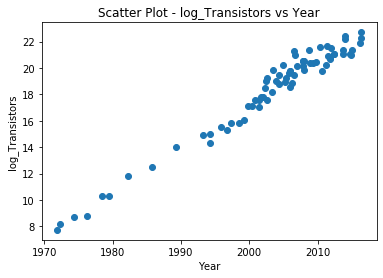

In [8]:
plt.scatter(trans_df_2.rdd.map(lambda row: row.Year).collect(), 
            trans_df_2.rdd.map(lambda row: row.log_Transistors).collect())
plt.xlabel("Year")
plt.ylabel("log_Transistors")
plt.title("Scatter Plot - log_Transistors vs Year")

plt.show()

##### Grading Feedback Cell

## Question 5 Fit a Linear Regression Pipeline (10 pts)

### Question 5a ( 2 pts)
- Split trans_df_2 into train and test splits with a 60:40 ratio.  Name the resulting data frames trans_train and trans_test.  Print the shape of of the train and test data frames.

In [9]:
trans_train, trans_test = trans_df_2.randomSplit([0.6, 0.4], seed = 11)

print("Shape of train dataframe:", (trans_train.count(), len(trans_train.columns)))

print("Shape of test dataframe:", (trans_test.count(), len(trans_test.columns)))

Shape of train dataframe: (44, 3)
Shape of test dataframe: (30, 3)


##### Grading Feedback Cell

### Question 5b (6 pts)
- Create a spark pipeline named trans_pipe to perform linear regression
- Fit the pipeline using the transistors as the targets and year as the features.  Name the resulting fitted pipeline fitted_trans_pipe.
- Fit another pipeline using the log transistors column as the targets and year as the features.  Name the resulting fitted pipeline log_fitted_trans_pipe.

In [10]:
from pyspark.ml import feature, regression, evaluation, Pipeline

trans_pipe = Pipeline(stages = [feature.VectorAssembler(inputCols = ['Year'], outputCol='features'),
                                regression.LinearRegression(featuresCol = 'features', labelCol = 'Transistors')])

fitted_trans_pipe = trans_pipe.fit(trans_train)

log_fitted_trans_pipe = Pipeline(stages = [feature.VectorAssembler(inputCols = ['Year'], outputCol='features'),
                                           regression.LinearRegression(featuresCol = 'features', labelCol = 'log_Transistors')]).fit(trans_train)

##### Grading Feedback Cell

### Question 5c (2 pts)
- Print the linear regression coefficient in the linear regression object in each fitted model
- Print the linear regression Y intercept in the linear regression object in each fitted model

In [11]:
print("trans fitted model")

print("Coefficient:", fitted_trans_pipe.stages[1].coefficients)

print("Intercept:", fitted_trans_pipe.stages[1].intercept)

print("\nlog fitted model")

print("Coefficient:", log_fitted_trans_pipe.stages[1].coefficients)

print("Intercept:", log_fitted_trans_pipe.stages[1].intercept)

trans fitted model
Coefficient: [70831544.48925729]
Intercept: -140966842837.0843

log fitted model
Coefficient: [0.330169416023645]
Intercept: -642.9934672105999


##### Grading Feedback Cell

### Question 6 Test the linear regression pipeline (10 pts)

### Question 6a (5 pts)
- Compute mean squared error (MSE) using the transform method on each fitted model.
- Print the resulting MSEs.

In [12]:
mse = fn.mean((fn.col('Transistors') - fn.col('prediction')) ** 2).alias('mse')

print("MSE for trans fitted model:")

fitted_trans_pipe.transform(trans_test).select(mse).show()

mse = fn.mean((fn.col('log_Transistors') - fn.col('prediction')) ** 2).alias('mse')

print("MSE for log fitted model:")

log_fitted_trans_pipe.transform(trans_test).select(mse).show()

MSE for trans fitted model:
+--------------------+
|                 mse|
+--------------------+
|7.278821655465393...|
+--------------------+

MSE for log fitted model:
+-----------------+
|              mse|
+-----------------+
|0.379895002162536|
+-----------------+



##### Grading Feedback Cell

### Question 6b (5 pts)
- Using log_fitted_trans_pipe and any needed support code, predict and print the number of transistors for the years 1970.0, 1980.0, 1990.0, 2000.0, and 2010.0

In [13]:
years = [1970.0, 1980.0, 1990.0, 2000.0, 2010.0]

print("Year \t Prediction")

for x in years:  
    
    y = np.exp(((log_fitted_trans_pipe.stages[1].coefficients) * x) + (log_fitted_trans_pipe.stages[1].intercept))
    
    print(x, "\t", y)

Year 	 Prediction
1970.0 	 [1703.23107074]
1980.0 	 [46257.3901044]
1990.0 	 [1256286.46401989]
2000.0 	 [34118995.3890028]
2010.0 	 [9.26624524e+08]


##### Grading Feedback Cell

# Climate Change

## Question 7 Load the global warming data (5 pts)
- Read the globalWarm.txt file into a spark data frame named global_warm_df using only spark.  The columns should be named as per the header in the txt file.
- Print the first 5 rows of global_warm_df 
- Print the shape of global_warm_df (num_rows, num_cols)
- Make sure to use the get_training_filename function above to obtain the file name based on your runtime environment
- A data description follows:
<ul>
<li/>Temp = annual surface temperature measured in 1/100<sup>o</sup> C   over the 1950-1980 mean.  
<li/>Solar = annual mean intensity of sunlight piercing the atmosphere
<li/>CO2 = annual average fraction CO<sub>2</sub> in atmosphere (#molecules/#molecules of dry air) 
<li/>IceShelf = sea ice in 1MM square miles  hypothesized to reflect heat
<li/>Transmission = volcanic MLO transmission data where eruptions release greenhouse gases but also decrease the temperature
</ul>

In [14]:
data_rdd = sc.textFile(get_training_filename('globalWarm.txt'))

def map_globalwarm(e):
    
    x = e.split('\t')
    
    return Row(Year = x[0], Temp = x[1], CO2 = x[2], Solar = x[3], Transmission = x[4], IceShelf = x[5])

global_warm_df = data_rdd.map(map_globalwarm).filter(lambda x: x[0] != 'CO2').toDF()

global_warm_df = global_warm_df.selectExpr("cast(Year as int) Year", 
                                           "cast(Temp as int) Temp",
                                           "cast(CO2 as float) CO2",
                                           "cast(Solar as float) Solar",
                                           "cast(Transmission as float) Transmission",
                                           "cast(IceShelf as float) IceShelf")
global_warm_df.show(5)

print("Shape of global_warm_df:", (global_warm_df.count(), len(global_warm_df.columns)))

+----+----+------+-------+------------+--------+
|Year|Temp|   CO2|  Solar|Transmission|IceShelf|
+----+----+------+-------+------------+--------+
|1979|   8|336.67|1366.43|   0.9284667|     7.2|
|1980|  19|338.57|1366.51|  0.92966664|    7.85|
|1981|  26|339.92|1366.51|  0.92976665|    7.25|
|1982|   4| 341.3|1366.16|   0.8530667|    7.45|
|1983|  25|342.71|1366.18|  0.89771664|    7.52|
+----+----+------+-------+------------+--------+
only showing top 5 rows

Shape of global_warm_df: (32, 6)


##### Grading Feedback Cell

## Question 8 Global Warming Data Exploration (5 pts)
- Create a temperature vs. year scatter plot from global_warm_df
- You may use packages outside of spark for this question

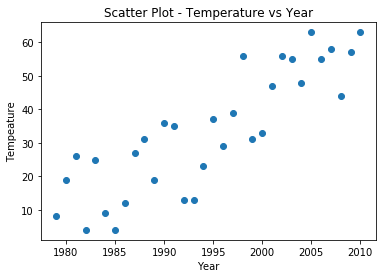

In [15]:
plt.scatter(global_warm_df.rdd.map(lambda row: row.Year).collect(), 
            global_warm_df.rdd.map(lambda row: row.Temp).collect())
plt.xlabel("Year")
plt.ylabel("Tempeature")
plt.title("Scatter Plot - Temperature vs Year")

plt.show()

##### Grading Feedback Cell

## Question 9 Global Warming Data Exploration (10 pts)


### Question 9a (5 pts)
- Using global_warm_df, create a pair plot of the following variables in a grid:  Temp, CO<sub>2</sub>, Solar, Transmission, and IceShelf.
- You may use packages outside of spark for this question

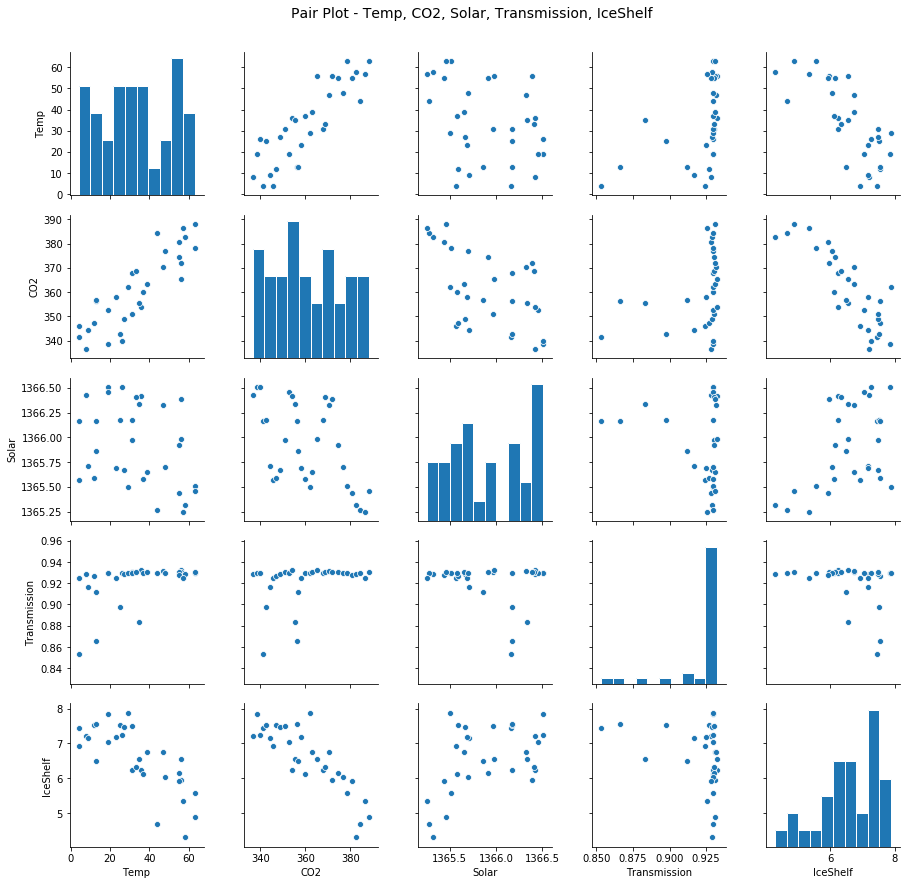

In [16]:
%matplotlib inline
import seaborn as sns

pgw_df = global_warm_df.toPandas()
pgw_df = pgw_df.drop(columns = 'Year')

grid = sns.pairplot(pgw_df)
grid.map_diag(plt.hist, edgecolor = "w")

f = grid.fig
f.suptitle("Pair Plot - Temp, CO2, Solar, Transmission, IceShelf", fontsize = 14)
f.subplots_adjust(top=0.93, wspace=0.3)

plt.show(f)

##### Grading Feedback Cell

### Question 9b (5 pts)
- Compute a correlation matrix between Temp, CO<sub>2</sub>, Solar, Transmission, and IceShelf using spark.
- Print a labeled correlation matrix.

In [17]:
from pyspark.ml.stat import Correlation

df = feature.VectorAssembler(inputCols = ['Temp', 'CO2', 'Solar', 'Transmission', 'IceShelf'], 
                             outputCol = "features").transform(global_warm_df)

corr_matrix = Correlation.corr(df, "features").head()

rows = corr_matrix[0].toArray().tolist()
features = ('Temp', 'CO2', 'Solar', 'Transmission', 'IceShelf')

for i in range(len(features)):
    
    rows[i].insert(0, features[i])

cor_df = spark.createDataFrame(rows, ['Correlation_Matrix', 'Temp', 'CO2', 'Solar', 'Transmission', 'IceShelf'])
cor_df = cor_df.selectExpr("cast(Correlation_Matrix as string) Correlation_Matrix", 
                     "cast(Temp as float) Temp",
                     "cast(CO2 as float) CO2",
                     "cast(Solar as float) Solar",
                     "cast(Transmission as float) Transmission",
                     "cast(IceShelf as float) IceShelf")
cor_df.show()


+------------------+-----------+-----------+-----------+------------+-----------+
|Correlation_Matrix|       Temp|        CO2|      Solar|Transmission|   IceShelf|
+------------------+-----------+-----------+-----------+------------+-----------+
|              Temp|        1.0|  0.8609275|-0.34034297|  0.43539405| -0.7474255|
|               CO2|  0.8609275|        1.0|-0.54282194|   0.3282278| -0.8469608|
|             Solar|-0.34034297|-0.54282194|        1.0|  -0.2058605| 0.47069034|
|      Transmission| 0.43539405|  0.3282278| -0.2058605|         1.0|-0.30248398|
|          IceShelf| -0.7474255| -0.8469608| 0.47069034| -0.30248398|        1.0|
+------------------+-----------+-----------+-----------+------------+-----------+



##### Grading Feedback Cell

## Question 10 Fit Linear Regression Pipelines (10 pts)

### Question 10a (2 pts)
Split global_warm_df into train and test splits with a 60:40 ratio.  Name the resulting data frames gw_train and gw_test.  Print the shape of of the train and test data frames.   

In [18]:
gw_train, gw_test = global_warm_df.randomSplit([0.6, 0.4], seed = 12)

print("Shape of train dataframe:", (gw_train.count(), len(gw_train.columns)))

print("Shape of test dataframe:", (gw_test.count(), len(gw_test.columns)))

Shape of train dataframe: (19, 6)
Shape of test dataframe: (13, 6)


##### Grading Feedback Cell

### Question 10b (6 pts)
- Create a spark pipeline named global_warm_pipe to perform linear regression.
- Use the global_warm_df data frame
- Fit a pipeline on the temp column as the target and CO2 as the feature.  Name the resulting fitted pipeline fitted_global_warm_pipe.
- Fit another pipeline on the temp column as the target and all other columns except year as the features.  Name the resulting fitted pipeline fitted_global_warm_pipe_2.

In [19]:
global_warm_pipe = Pipeline(stages = [feature.VectorAssembler(inputCols = ['CO2'], outputCol='features'),
                                      regression.LinearRegression(featuresCol = 'features', labelCol = 'Temp')])

fitted_global_warm_pipe = global_warm_pipe.fit(gw_train)

fitted_global_warm_pipe_2 = Pipeline(stages = [feature.VectorAssembler(inputCols = ['CO2', 'Solar', 'Transmission', 'IceShelf'], outputCol='features'),
                                               regression.LinearRegression(featuresCol = 'features', labelCol = 'Temp')]).fit(gw_train)

##### Grading Feedback Cell

### Question 10c (2 pts)
- Print the linear regression coefficient(s) in the linear regression object in each fitted model
- Print the linear regression Y intercept in the linear regression object in each fitted model

In [20]:
print("Model 1")

print("Coefficient:", fitted_global_warm_pipe.stages[1].coefficients)

print("Intercept:", fitted_global_warm_pipe.stages[1].intercept)

print("\nModel 2")

print("Coefficient:", fitted_global_warm_pipe_2.stages[1].coefficients)

print("Intercept:", fitted_global_warm_pipe_2.stages[1].intercept)

Model 1
Coefficient: [0.8798406701290213]
Intercept: -281.11507345537973

Model 2
Coefficient: [0.8936794097950107,8.011344551208783,168.03797084940905,-1.827942874965872]
Intercept: -11372.662335212566


##### Grading Feedback Cell

### Question 11 Test the linear regression pipeline (10 pts)

### Question 11a (5 pts)
- Compute mean squared error (MSE) using the transform method on each fitted model.
- Print the resulting MSEs.

In [21]:
mse = fn.mean((fn.col('Temp') - fn.col('prediction')) ** 2).alias('mse')

print("MSE for model 1:")

fitted_global_warm_pipe.transform(gw_test).select(mse).show()

print("MSE for model 2:")

fitted_global_warm_pipe_2.transform(gw_test).select(mse).show()

MSE for model 1:
+------------------+
|               mse|
+------------------+
|132.88955318312426|
+------------------+

MSE for model 2:
+-----------------+
|              mse|
+-----------------+
|97.21417568028954|
+-----------------+



##### Grading Feedback Cell

### Question 11b (5 pts)
- Which of the 2 models have higher performance.  In the cell below, describe why you think the better performing model made the model perform better.

- Model 2 has high performance than model 1 as it has lower MSE.
- One reason why model 2 performs better could be because it has 4 explanatory variables, while model 1 has just 1 explanatory variable. The 4 explanatory variables in model 2 together predict Temp more precisely than CO2 alone in model 1.

### Question 12 Inference (10 pts)

### Question 12a Data Scaling (5 pts)
Add data scaling to fitted_global_warm_pipe_2 above. Name the resulting fitted model fitted_global_warm_pipe_3.  Print the resulting fitted model coefficients such that each coefficient is clearly labeled with it's corresponding feature name.

In [22]:
fitted_global_warm_pipe_3 = Pipeline(stages = [feature.VectorAssembler(inputCols = ['CO2', 'Solar', 'Transmission', 'IceShelf'], outputCol='features'),
                                               feature.StandardScaler(inputCol = 'features', outputCol = 'scaledFeatures', withStd = True, withMean = True),
                                               regression.LinearRegression(featuresCol = 'scaledFeatures', labelCol = 'Temp')]).fit(gw_train)

print("Model 3 coefficients")

print("CO2:", fitted_global_warm_pipe_3.stages[2].coefficients[0])

print("Solar:", fitted_global_warm_pipe_3.stages[2].coefficients[1])

print("Transmission:", fitted_global_warm_pipe_3.stages[2].coefficients[2])

print("IceShelf:", fitted_global_warm_pipe_3.stages[2].coefficients[3])

Model 3 coefficients
CO2: 14.400342550378179
Solar: 3.69445696498837
Transmission: 3.1268456590488296
IceShelf: -1.756452307902348


### Question 12b Inference (5 pts)  
Use the coefficients printed above to gain insights into the global warming problem. Describe your inference conclusions in the cell below.

- CO2, Solar and Transmission have a positive impact on Temp, thereby increasing global warming.
- IceShelf has negative impact on Temp and is not a contributor for global warming.
- CO2 is the major contributor for global warming.
- With every 1 unit increase in CO2, Temp increases by 14.4 units.
- With every 1 unit increase in Solar, Temp increases by 3.7 units.
- With every 1 unit increase in Transmission, Temp increases by 3.1 units.
- With every 1 unit increase in IceShelf, Temp decreases by 1.8 units.

##### Grading Feedback Cell

# Question 13 Extra Credit (10 pts)
This question is optional.  No points will be deducted from your score if you do not attempt this problem.<br>

Starting with the rdd class presented in lecture (maintaining all class method names), implement a my_reduce method in the rdd class.  Your implementation shall maintain rdd class immutability.  Your my_reduce method return type should be consistent with the return type in the real Spark reduce method. Do some research and see what the Spark reduce return type would be.  <br>

Implement a function named times_3 which returns its input multiplied by 3. Implement a function named is_even that returns true if it's input is even, false otherwise.  Implement a my_sum function that returns the sum of its 2 inputs.  <br>

Your overall implementation should not rely on receiving specific data types as inputs.  For example, the plus operator works on more than just ints and floats.

In [23]:
import numpy as np

def times_3(e):
    
    return 3 * e

def is_even(e):
    
    if e % 2 == 0:
        return True
    
    else:
        return False

def my_sum(v1, v2):
    
    return v1 + v2

class rdd:
    
    def __init__(self, data):
        
        self.array = data
    
    def my_map(self, fun):
        
        if len(self.array) < 1:
            raise Exception("my_map: len(local_array) < 1")
        
        mapped = np.empty_like(self.array)
        
        for i, e in enumerate(self.array):
            
            mapped[i] = fun(self.array[i])
            
        return rdd(mapped)
    
    def my_filter(self, fun):
        
        transformed = []
        
        for e in self.array:
            
            if fun(e):
                transformed.append(e)
                
        return rdd(np.array(transformed))
    
    def my_reduce(self, fun):
        
        add = 0
    
        for i in range(len(self.array)):
            
            add += fun(self.array[i] , self.array[i - 1]) - self.array[i]
            
        return add


In [24]:
# Simple test code
test_rdd = rdd(np.arange(100))
result = test_rdd.my_map(times_3).my_filter(is_even).my_reduce(my_sum)
print(type(result))
print(result)

# secret grading test code follows 


<class 'numpy.int64'>
7350


##### Grading Feedback Cell